<a href="https://colab.research.google.com/github/Llmortimer/character_morality/blob/main/DissertationFilmAnalyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install -y ffmpeg
!pip install --upgrade google-cloud-language
!pip install --upgrade google-cloud
!pip install scenedetect

import re
import sys
import locale
import string
import os
import json
import argparse
import statistics
import pandas as pd
import numpy as np
import networkx as nx
import collections
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as mpl
from difflib import SequenceMatcher
from operator import itemgetter

from scenedetect import VideoManager
from scenedetect import SceneManager

# For content-aware scene detection:
from scenedetect.detectors import ContentDetector
from scenedetect.detectors import AdaptiveDetector

from google.cloud import language_v1
# from google.cloud.language import enums
from google.cloud.language_v1 import types
# from google.oauth2 import service_account

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
     |████████████████████████████████| 82 kB 206 kB/s 
     |████████████████████████████████| 46 kB 4.3 MB/s 
     |████████████████████████████████| 1.0 MB 65.3 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: google-cloud-language
    Found existing installation: google-cloud-language 1.2.0
    Uninstalling google-cloud-language-1.2.0:
      Successfully uninstalled google-cloud-language-1.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021

     |████████████████████████████████| 98 kB 6.5 MB/s 


In [ ]:
title = "IndianaLastCrusade"
# title = "TheAvengers" # generally extremely negative 
# title = "StarWarsTESB"
# title = "HarryPotterDHP2" # not working script issues
# title = "TheDarkKnight"
# title = "TheHungerGames" # script and subtitles not aligning
# title = "Aladdin" # songs make the subtitles and script not align properly
# title = "ToyStory"
# title = "NoCountryForOldMen"
# title = "ShawshankRedemption"

input_script = '/content/drive/MyDrive/shared/Scripts_and_Films/' + title + '/' + title + 'Script.txt'
input_subtitles = '/content/drive/MyDrive/shared/Scripts_and_Films/' + title + '/' + title + 'Subtitles.srt'
dialogue_script = '/content/drive/MyDrive/shared/Scripts_and_Films/' + title + '/' + title + 'Dialogue.txt'
sentiment_analysis = '/content/drive/MyDrive/shared/Scripts_and_Films/' + title + '/' + title + 'Sentiment.txt'
input_film = '/content/drive/MyDrive/shared/Scripts_and_Films/' + title + '/' + title + 'Film.mp4'
scene_threshold = "02"
adaptive_threshold = 25
# scene_threshold = ""
extracted_scenes = '/content/drive/MyDrive/shared/Scripts_and_Films/' + title + '/scenes' + scene_threshold + '/time.txt'
json_scenes =  '/content/drive/MyDrive/shared/Scripts_and_Films/' + title + '/adscenes' + str(adaptive_threshold) + '/json_scenes.json'

# np.set_printoptions(threshold=1000, edgeitems=100)

In [ ]:
#pre-process subtitles by extractings start and end times of each dialogue.
f = open(input_subtitles).read()

matches = re.findall(r"([0-9]*)\n(.+)--> (.+)\n((.+\n{0,1})+)", f, re.M)
id = []
start = []
end = []
dialogue_sub = []
doubled = 0
for i in matches:
    ex = i[3].rstrip().replace('\n', ' ')
    ex = re.sub('<[^<]+?>', '', ex)
    if title == "HarryPotterDHP2" or title == "TheHungerGames":
        sounds = re.match(r"\([A-Z ]+\)", ex)
    elif title == "ToyStory":
        sounds = re.match(r".*♪.+", ex)
    else:
        sounds = re.match(r"\[[A-Z ]+\]", ex)

    names = re.match(r"[A-Z ]+: ", ex)

    if sounds:
        print(sounds)
        continue
    if names:
        print(names.group(0))
        ex = ex.replace(names.group(0), '')


    ex = re.sub("[\(\[].*?[\)\]]", "", ex)
    ex = ex.strip(" -")
    ex = ex.split(" - ")
    for j, e in enumerate(ex):
        doubled += j
        id.append(str(int(i[0])+doubled))
        start.append(i[1])
        end.append(i[2])
        dialogue_sub.append(e)

NameError: ignored

In [ ]:
for i in dialogue_sub:
    print(i)

In [ ]:
#pre-process script by extracting the dialogue and character names writing to seperate file.
f = open(input_script).read()
if title == "Aladdin":
    matches = re.findall(r"([A-Z ]+):\s*([A-Za-z ,?.'!\/()\-\s]+)$", f, re.M)
elif title == "ShawshankRedemption":
    matches = re.findall(r"\n\s+([A-Z .()]+)\n *((.+\s)*)", f, re.M)
else:
    matches = re.findall(r"\n\s+([A-Z ]+)\n *((.+\s)*)", f, re.M)
dialogue = []
characters = []
for i in matches:
    if '' not in i:
        j = " ".join(i[1].split())
        if title == "Aladdin":
            j = re.sub("[\(\[].*?[\)\]]", "", j)
            j = j.split()
        dialogue.append(re.sub("[\(\[].*?[\)\]]", "", j))
        characters.append(re.sub("[\(\[].*?[\)\]]", "", i[0]))

        

with open(dialogue_script, "w") as ds:
    for inst in dialogue:
        ds.write(inst+"\n")

In [ ]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

# combined = [(1.0, 0, 0, 0, dialogue_sub[0], dialogue[0])]
combined = []
last = 0
sub = 0
threshold = 0.7 #shawshank = 0.5, 25 - indiana = 0.7, 10 - star wars = 0.7, 10 - dark knight = 0.7, 10, toy story = 0.6, 10
last_offset = 10
for c, i in enumerate(dialogue_sub):
    for count, j in enumerate(dialogue):

        if similar(i, j) > threshold and count > last and count <= last + last_offset: 
            combined.append((similar(i, j), c, count, i, j))
            last = count
            # sub = c
            break

        # if count > last + 25:
        #     last+=5
        #     break
        # if c > sub + 30:
        #     last += 2
        # if count > last and count < last + 10:
        #     missed += 1

        # if missed > 20:


list1 = []
list2 = []

last_sub = -1
last_script = -1

for c in combined:
    if c[1] > last_sub+1:
        list1.append(list(range(last_sub+1, c[1])))
    elif c[1] == last_sub+1:
        list1.append([])

    list1.append([c[1]])
    last_sub = c[1]

    if c[2] > last_script+1:
        list2.append(list(range(last_script+1, c[2])))
    elif c[2] == last_script+1:
        list2.append([])

    list2.append([c[2]])
    last_script = c[2]

list1.append(list(range(last_sub+1, len(dialogue_sub))))
list2.append(list(range(last_script+1, len(dialogue))))

In [ ]:
for c in combined:
    print(c)

In [ ]:
blocks = []
grouped_dialogue = []

blocks.append([(0, 0, (combined[0], combined[0]))])
for c in range(1, len(combined)):
    # if combined[c-1][1] + 1 != combined[c][1]:
    blocks.append([(combined[c-1][1], combined[c-1][2]), (combined[c][1], combined[c][2])])

blocks.append([(combined[-1][1], combined[-1][2]),(len(dialogue_sub)-1, len(dialogue)-1)]) 
# print(blocks)
# assignments = []

for c in range(1, len(blocks)):
    scr_range = list(range(blocks[c-1][0][1], blocks[c][1][1]))
    sub_range = list(range(blocks[c-1][0][0], blocks[c][1][0]))
    grouped_dialogue.append((dialogue[blocks[c-1][0][1]:blocks[c][1][1]], dialogue_sub[blocks[c-1][0][0]:blocks[c][1][0]], scr_range, sub_range))

for g in grouped_dialogue:
    print(g)

In [ ]:
def construct_matrix(scripts, subtitles):
    similarity_matrix = [[100] * len(subtitles) for i in range(len(scripts))]
    for i, script in enumerate(scripts):
        for j, subtitle in enumerate(subtitles):
            if similar(subtitle, script) >= 0.6:
                similarity_matrix[i][j] = 1

    return similarity_matrix

def coords(row, col):
    return np.array(list(np.ndindex((row, col)))).reshape(row, col, 2).tolist()
    # return np.array(list(np.ndindex((row, col))), dtype=object).reshape(row, col)

def find_path(cost, R, C):
    m = R - 1
    n = C - 1
    pc = coords(R, C)
    tc = [[0 for x in range(C)] for x in range(R)]

    tc[0][0] = cost[0][0]
 
    # Initialize first column of total cost(tc) array
    for i in range(1, m+1):
        tc[i][0] = tc[i-1][0] + cost[i][0]        
        pc[i][0].extend(pc[i-1][0])
    # Initialize first row of tc array
    for j in range(1, n+1):
        tc[0][j] = tc[0][j-1] + cost[0][j]
        pc[0][j].extend(pc[0][j-1])

 
    # Construct rest of the tc array
    for i in range(1, m+1):
        for j in range(1, n+1):
            tc[i][j] = min(tc[i-1][j-1], tc[i-1][j], tc[i][j-1]) + cost[i][j]
            if tc[i-1][j-1] < tc[i-1][j] and tc[i-1][j-1] < tc[i][j-1]:
                pc[i][j].extend(pc[i-1][j-1])
            elif tc[i-1][j] < tc[i][j-1]:
                pc[i][j].extend(pc[i-1][j])
            else:
                pc[i][j].extend(pc[i][j-1])


    path = []
    for count in range(1, len(pc[i][j]), 2):
        path.append((pc[m][n][count-1], pc[m][n][count]))

    path.reverse()
    return tc[m][n], path

output_list = []

for groupID, group in enumerate(grouped_dialogue):
    in_script = " ".join(group[0]).split()
    in_sub = " ".join(group[1]).split()

    details = []
    script_lengths = []
    sub_lengths = []

    for c, i in enumerate(group[0]):
        # script_lengths.append(len(i.split()) + script_lengths[i])
        if c == 0:
            script_lengths.append(len(i.split())-1)
        else:
            script_lengths.append(len(i.split())+script_lengths[c-1])

    for c, i in enumerate(group[1]):
        # sub_lengths.append(len(i.split())-1)
        if c == 0:
            sub_lengths.append(len(i.split())-1)
        else:
            sub_lengths.append(len(i.split())+sub_lengths[c-1])


    matrix = construct_matrix(in_script, in_sub)
    if len(matrix) == 0:
        continue
    cost, path = find_path(matrix, len(in_script), len(in_sub))
    for node in path:
        script, sub = node
        idxScr = 0
        idxSub = 0
        details.append((in_script[script], script, in_sub[sub], sub, matrix[script][sub]))

    offset = 0
    script_offset = 0
    sub_offset = 0
    script_idx_offset = 0
    sub_idx_offset = 0
    idx = 0
    current = []
    currentScript = []
    currentSub = []
    compiled_scripts = []
    compiled_subs = []
    # print(path)
    # print(script_lengths, sub_lengths)
    # print(len(details))

    dialogue_num = 0
    sub_offset = 0
    script_offset = 0
    similarities = []
    sub_added = False
    script_added = False
    
    for count, detail in enumerate(details):

        scriptWordID = detail[1]
        subWordID = detail[3]

        # print(detail[0], detail[2])

        if count == len(details)-1:
            currentScript.append(detail[0])
            currentSub.append(detail[2])
            similarities.append(detail[4])
            compiled_scripts.append(currentScript)
            compiled_subs.append(currentSub)
            # print((compiled_scripts, compiled_subs))
            output_list.append((groupID+dialogue_num, compiled_scripts, compiled_subs, similarities, group[2][dialogue_num:dialogue_num+script_offset+1], group[3][dialogue_num:dialogue_num+sub_offset+1]))
            break

        if scriptWordID <= script_lengths[dialogue_num+script_offset] and subWordID <= sub_lengths[dialogue_num+sub_offset]:
            #do something
            currentScript.append(detail[0])
            currentSub.append(detail[2])
            similarities.append(detail[4])

        elif scriptWordID > script_lengths[dialogue_num+script_offset] and subWordID <= sub_lengths[dialogue_num+sub_offset]:
            compiled_scripts.append(currentScript)
            if sub_added:
                output_list.append((groupID+dialogue_num, compiled_scripts, compiled_subs, similarities, group[2][dialogue_num:dialogue_num+script_offset+1], group[3][dialogue_num:dialogue_num+sub_offset+1]))
                currentScript = []
                similarities = []
                currentSub = []
                compiled_subs = []
                compiled_scripts = []
                sub_added = False
            else:
                script_added = True
                currentScript = []

            script_offset += 1
            currentScript.append(detail[0])
            currentSub.append(detail[2])
            similarities.append(detail[4])

        elif scriptWordID <= script_lengths[dialogue_num+script_offset] and subWordID > sub_lengths[dialogue_num+sub_offset]:
            compiled_subs.append(currentSub)
            if script_added:
                output_list.append((groupID+dialogue_num, compiled_scripts, compiled_subs, similarities, group[2][dialogue_num:dialogue_num+script_offset+1], group[3][dialogue_num:dialogue_num+sub_offset+1]))
                currentScript = []
                similarities = []
                currentSub = []
                compiled_subs = []
                compiled_scripts = []
                script_added = False
            else:
                sub_added = True
                currentSub = []

            sub_offset += 1
            currentScript.append(detail[0])
            currentSub.append(detail[2])
            similarities.append(detail[4])

        else:
            compiled_scripts.append(currentScript)
            compiled_subs.append(currentSub)
            output_list.append((groupID+dialogue_num, compiled_scripts, compiled_subs, similarities, group[2][dialogue_num:dialogue_num+script_offset+1], group[3][dialogue_num:dialogue_num+sub_offset+1]))
            currentScript = []
            similarities = []
            currentSub = []
            compiled_subs = []
            compiled_scripts = []
            dialogue_num+=1
            currentScript.append(detail[0])
            currentSub.append(detail[2])
            similarities.append(detail[4])
            sub_added = False
            Script_added = False

collected_dialogue = []

for o in output_list:
    print(o)
    d_count = 0
    script_out = []
    sub_out = []
    script_idx = []
    sub_idx = []
    for d in o[3]:
        if d == 1:
            d_count += 1

    # print(d_count, len(o[3]))
    if d_count/len(o[3]) > 0.5:
        for c, i in enumerate(o[1]):
            # script_idx.append(o[4][c])
            script_out.append(" ".join(i))

        for c, i in enumerate(o[2]):
            # sub_idx.append(o[5][c])
            sub_out.append(" ".join(i))


        # print(o[4], script_idx)
        # print(o[5], sub_idx)

        # print(*script_out, sep=", ")
        # # print("is similar to")
        # print(*sub_out, sep=", ")

        scripts = []
        subs = []
        char = []
        time = []
        scr_num = []
        sub_num = []
        for scr in o[4]:
            for scr_out in script_out:
                if similar(scr_out, dialogue[scr]) >= 0.7:
                    scripts.append(dialogue[scr])
                    scr_num.append(scr)
                    char.append(characters[scr])

        for sub in o[5]:
            for subs_out in sub_out:
                if similar(subs_out, dialogue_sub[sub]) >= 0.7:
                    subs.append(dialogue_sub[sub])
                    sub_num.append(sub)
            
        time.append((start[o[5][0]], end[o[5][-1]]))

        to_add = ([char, sub_num, scr_num, subs, scripts, start[o[5][0]], end[o[5][-1]]])

        if to_add not in collected_dialogue and len(subs) != 0 and len(scripts) != 0:
            collected_dialogue.append([char, sub_num, scr_num, subs, scripts, start[o[5][0]], end[o[5][-1]]])

# print(collected_dialogue)
to_remove = []

for c in range(len(collected_dialogue)-2, 0, -1):
    # print(collected_dialogue[c])
    if collected_dialogue[c][1] == collected_dialogue[c+1][1]:
        if similar(" ".join(collected_dialogue[c][3]), " ".join(collected_dialogue[c][4])) > similar(" ".join(collected_dialogue[c+1][3]), " ".join(collected_dialogue[c+1][4])):
            # print(" ".join(collected_dialogue[c][1]) + " is closer to " + " ".join(collected_dialogue[c][2]))
            # print(" ".join(collected_dialogue[c+1][1]) + " is not closer to " + " ".join(collected_dialogue[c+1][2]))
            to_remove.append(c+1)
            # del collected_dialogue[c+1]
        else:
            # print(" ".join(collected_dialogue[c][1]) + " is not closer to " + " ".join(collected_dialogue[c][2]))
            # print(" ".join(collected_dialogue[c+1][1]) + " is closer to " + " ".join(collected_dialogue[c+1][2])) 
            to_remove.append(c)
            # del collected_dialogue[c]
            continue

    if collected_dialogue[c][2] == collected_dialogue[c+1][2]:
        if similar(" ".join(collected_dialogue[c][3]), " ".join(collected_dialogue[c][4])) > similar(" ".join(collected_dialogue[c+1][3]), " ".join(collected_dialogue[c+1][4])):
            # print(" ".join(collected_dialogue[c][1]) + " is closer to " + " ".join(collected_dialogue[c][2]))
            # print(" ".join(collected_dialogue[c+1][1]) + " is not closer to " + " ".join(collected_dialogue[c+1][2]))
            to_remove.append(c+1)
            # del collected_dialogue[c+1]
        else:
            # print(" ".join(collected_dialogue[c][1]) + " is not closer to " + " ".join(collected_dialogue[c][2]))
            # print(" ".join(collected_dialogue[c+1][1]) + " is closer to " + " ".join(collected_dialogue[c+1][2])) 
            to_remove.append(c)
            # del collected_dialogue[c]
            continue

    # if len(collected_dialogue[c][0]) >= 2:
        # to_remove.append(c)
        # del collected_dialogue[c]
        # continue

# for i in range(0, len(collected_dialogue)):
#     for c in collected_dialogue:
#         if collected_dialogue[i][2] == c[2]:

print(to_remove)
for r in to_remove:
    del collected_dialogue[r]

to_remove = []

for c in range(0, len(collected_dialogue)):
    for d in range(0, len(collected_dialogue)):
        # print(collected_dialogue[c][1], collected_dialogue[d][1])
        # print(str(collected_dialogue[c][1] in collected_dialogue[d][1]) + " and " + str(collected_dialogue[c][2] in collected_dialogue[d][2]))
        if all(item in collected_dialogue[c][1] for item in collected_dialogue[d][1]) and all(item in collected_dialogue[c][2] for item in collected_dialogue[d][2]) and not (collected_dialogue[c][1] == collected_dialogue[d][1] and collected_dialogue[c][2] == collected_dialogue[d][2]):
            # print(str(collected_dialogue[d][3]) + " in and remove " + str(collected_dialogue[c][3]))
            to_remove.append(c)
#     if collected_dialogue[2] in dupes: 
#             similar(" ".join(collected_dialogue[c][3]), " ".join(collected_dialogue[c][4])) > similar(" ".join(collected_dialogue[c+1][3]), " ".join(collected_dialogue[c+1][4])):


to_remove = list(dict.fromkeys(to_remove))
to_remove.reverse()
print(to_remove)
for r in to_remove:
    del collected_dialogue[r]

for c in range(0, len(collected_dialogue)):
    print(collected_dialogue[c])
   


In [ ]:
char_annotated = []

for sbt, sct in zip(list1, list2):
    char = []
    dia = []
    diaSbt = []
    for i in sct:
        char.append(characters[i])
        dia.append(dialogue[i])
    
    for i in sbt:
        diaSbt.append(dialogue_sub[i])

    if len(sbt) != 0 and len(sct) != 0: 
        char_annotated.append([char, sbt, sct, diaSbt, dia, start[sbt[0]], end[sbt[-1]]])
    elif len(sbt) == 0 and len(sct) != 0:
        char_annotated.append([char, sbt, sct, ['no subtitle dialogue'], dia, 'no time info', 'no time info'])
    elif len(sct) == 0 and len(sbt) != 0 :
        char_annotated.append([['null'], sbt, sct, diaSbt, ['no script dialogue'], start[sbt[0]], end[sbt[-1]]])

In [ ]:
edits = []

print(len(char_annotated))

for count, dialogue in enumerate(char_annotated):
    #where the speaker of the dialogue is set to 'null'
    if dialogue[0] == ['null']:
        #we only consider the subtitle dialogues to move to other peices of dialogue as monologues exist within the script
        query_dialogues = dialogue[3]
        print(query_dialogues)
        #for every line in the script dialogues
        for i, query_dialogue in enumerate(query_dialogues):
            #check if it is present in the previous or the post dialogues
            if query_dialogue.translate(str.maketrans('', '', string.punctuation)) in char_annotated[count-1][4][0].translate(str.maketrans('', '', string.punctuation)) and query_dialogue not in char_annotated[count-1][3][0]:
                #if its present in the previous script dialogue but not in the subtitles dialogue: add details to a list of edits to do
                edits.append((count, count-1, dialogue[1][i], len(query_dialogues)-i, query_dialogue))
            elif count+1 >= len(char_annotated):
                continue
            elif query_dialogue in char_annotated[count+1][4][0] and query_dialogue not in char_annotated[count+1][3][0]:
                #if it is present in the next script dialogue but not in the subtitles dialogue: add details to a list of edits to do
                edits.append((count, count+1, dialogue[1][i], len(query_dialogues)-i, query_dialogue))


In [ ]:
for c in edits:
    print(c)

In [ ]:
#in the list edits there contains: (index of line in char_annotated to be moved, index of what line it should be in, exact id of the line to be moved, if it is moved forwards or backwards, the line to be moved)
for e in edits:
    if e[0] > e[1]:
        #append the literal line to the previous one 
        char_annotated[e[1]][3].append(e[4])
        #edit the end time of the appended line
        char_annotated[e[1]][6] = end[e[2]]
        #append the id of the line to the previous one
        char_annotated[e[1]][1].append(e[2])
    else:
        #insert the literal line to the beginning previous one 
        char_annotated[e[1]][3].insert(0, e[4])
        #edit the end time of the inserted line
        char_annotated[e[1]][6] = start[e[2]]
        #insert the id of the line to the previous one
        char_annotated[e[1]][1].insert(0, e[2])

i = 0
for e in edits:
    if e[3] == 1:
        del char_annotated[e[0]-i]
        i+=1

In [ ]:
for i in char_annotated:
    print(i)

In [ ]:
to_delete = []

for count, i in enumerate(char_annotated):
    if i[0] == ['null']:
        to_delete.append(count)

    if i[5] == 'no time info' and i[6] == 'no time info':
        to_delete.append(count)


for count, i in enumerate(to_delete):
    del char_annotated[i-count]

In [ ]:
final_dialogue = []

for i in collected_dialogue:
    for count, j in enumerate(i[0]):
        temp, ms = i[5].split(',')
        h, m, s = temp.split(':')
        start_time = int(h) * 3600 + int(m) * 60 + int(s) + float(ms)/1000
        temp, ms = i[6].split(',')
        h, m, s = temp.split(':')
        end_time = int(h) * 3600 + int(m) * 60 + int(s) + float(ms)/1000

        final_dialogue.append([j.strip(), i[4][count], start_time, end_time])


In [ ]:
for i in final_dialogue:
    print(i)

In [ ]:
#scene detection, for each frame assign a probablility that the scene has changed given the change of intensity of the pixels on the pervious frame.
#if this probablility is higher than 0.5 for a given frame the frame time, and probablilty have been output to a file "time.txt" and the frame itself output to a PNG in scenes/ 

!ffmpeg -i /content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/ToyStoryFilm.mp4 -filter_complex "select='gt(scene,0.9)',metadata=print:file=/content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/scenes09/time.txt" -vsync vfr /content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/scenes09/img%03d.png
!ffmpeg -i /content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/ToyStoryFilm.mp4 -filter_complex "select='gt(scene,0.8)',metadata=print:file=/content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/scenes08/time.txt" -vsync vfr /content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/scenes08/img%03d.png
!ffmpeg -i /content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/ToyStoryFilm.mp4 -filter_complex "select='gt(scene,0.7)',metadata=print:file=/content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/scenes07/time.txt" -vsync vfr /content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/scenes07/img%03d.png
!ffmpeg -i /content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/ToyStoryFilm.mp4 -filter_complex "select='gt(scene,0.6)',metadata=print:file=/content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/scenes06/time.txt" -vsync vfr /content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/scenes06/img%03d.png
!ffmpeg -i /content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/ToyStoryFilm.mp4 -filter_complex "select='gt(scene,0.5)',metadata=print:file=/content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/scenes05/time.txt" -vsync vfr /content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/scenes05/img%03d.png
!ffmpeg -i /content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/ToyStoryFilm.mkv -filter_complex "select='gt(scene,0.4)',metadata=print:file=/content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/scenes04/time.txt" -vsync vfr /content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/scenes04/img%03d.png
!ffmpeg -i /content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/ToyStoryFilm.mp4 -filter_complex "select='gt(scene,0.3)',metadata=print:file=/content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/scenes03/time.txt" -vsync vfr /content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/scenes03/img%03d.png
!ffmpeg -i /content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/ToyStoryFilm.mp4 -filter_complex "select='gt(scene,0.2)',metadata=print:file=/content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/scenes02/time.txt" -vsync vfr /content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/scenes02/img%03d.png
!ffmpeg -i /content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/ToyStoryFilm.mp4 -filter_complex "select='gt(scene,0.1)',metadata=print:file=/content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/scenes01/time.txt" -vsync vfr /content/drive/MyDrive/shared/Scripts_and_Films/ToyStory/scenes01/img%03d.png


In [ ]:
#extract the scene changes and their times from the text file generated by the scene change algorithm

f = open(extracted_scenes).read()
matches = re.findall(r"frame:([0-9]+).+pts_time:([0-9.]+)", f)

scenes = {}
previous = '0'

for match in matches:
    scenes[match[0]] = {}
    scenes[match[0]]['start'] = float(previous)
    scenes[match[0]]['end'] = float(match[1])
    previous = match[1]

In [ ]:
for s in scenes:
    print(s, scenes[s])

0 {'start': 0.0, 'end': 47.1722}
1 {'start': 47.1722, 'end': 58.8922}
2 {'start': 58.8922, 'end': 66.9002}
3 {'start': 66.9002, 'end': 79.5796}
4 {'start': 79.5796, 'end': 88.9223}
5 {'start': 88.9223, 'end': 102.186}
6 {'start': 102.186, 'end': 115.741}
7 {'start': 115.741, 'end': 118.785}
8 {'start': 118.785, 'end': 120.287}
9 {'start': 120.287, 'end': 122.831}
10 {'start': 122.831, 'end': 129.338}
11 {'start': 129.338, 'end': 140.39}
12 {'start': 140.39, 'end': 147.94}
13 {'start': 147.94, 'end': 164.206}
14 {'start': 164.206, 'end': 187.771}
15 {'start': 187.771, 'end': 197.573}
16 {'start': 197.573, 'end': 210.252}
17 {'start': 210.252, 'end': 222.097}
18 {'start': 222.097, 'end': 226.435}
19 {'start': 226.435, 'end': 228.478}
20 {'start': 228.478, 'end': 232.858}
21 {'start': 232.858, 'end': 237.905}
22 {'start': 237.905, 'end': 242.075}
23 {'start': 242.075, 'end': 261.053}
24 {'start': 261.053, 'end': 264.932}
25 {'start': 264.932, 'end': 265.933}
26 {'start': 265.933, 'end': 2

In [ ]:
def find_scenes(video_path, threshold=3):
    # Create our video & scene managers, then add the detector.
    video_manager = VideoManager([video_path])
    scene_manager = SceneManager()
    scene_manager.add_detector(AdaptiveDetector(video_manager, adaptive_threshold=threshold))
    # Improve processing speed by downscaling before processing.
    video_manager.set_downscale_factor()

    # Start the video manager and perform the scene detection.
    video_manager.start()
    scene_manager.detect_scenes(frame_source=video_manager)

    # Each returned scene is a tuple of the (start, end) timecode.
    return scene_manager.get_scene_list()

frames = find_scenes(input_film, adaptive_threshold)

scenes = {}
for c, f in enumerate(frames):
    scenes[c] = {}
    scenes[c]["start"] = f[0].get_seconds()
    scenes[c]["end"] = f[1].get_seconds()

with open(json_scenes, 'w') as fp:
    json.dump(scenes, fp)

100%|██████████| 182539/182539 [21:08<00:00, 143.95frames/s]


In [ ]:
f = open (json_scenes, "r")
scenes = json.loads(f.read())
for s in scenes:
    print(scenes[s])

{'start': 0.0, 'end': 47.172172172172175}
{'start': 47.172172172172175, 'end': 58.89222555889223}
{'start': 58.89222555889223, 'end': 66.90023356690024}
{'start': 66.90023356690024, 'end': 79.57957957957959}
{'start': 79.57957957957959, 'end': 88.92225558892225}
{'start': 88.92225558892225, 'end': 129.33767100433766}
{'start': 129.33767100433766, 'end': 147.9396062729396}
{'start': 147.9396062729396, 'end': 158.3667000333667}
{'start': 158.3667000333667, 'end': 187.7711044377711}
{'start': 187.7711044377711, 'end': 226.43476810143477}
{'start': 226.43476810143477, 'end': 228.47847847847848}
{'start': 228.47847847847848, 'end': 232.85785785785788}
{'start': 232.85785785785788, 'end': 237.90457123790458}
{'start': 237.90457123790458, 'end': 242.0754087420754}
{'start': 242.0754087420754, 'end': 264.9315982649316}
{'start': 264.9315982649316, 'end': 265.9325992659326}
{'start': 265.9325992659326, 'end': 267.47580914247584}
{'start': 267.47580914247584, 'end': 301.63496830163496}
{'start':

In [ ]:
#true positives for scene changes indiana and the last crusade:
scenes_true = {}
scenes_true[1] = {}
scenes_true[1]["start"] = 0.0
scenes_true[1]["end"] = 147.940

scenes_true[2] = {}
scenes_true[2]["start"] = scenes_true[1]["end"]
scenes_true[2]["end"] = 287.246

scenes_true[3] = {}
scenes_true[3]["start"] = scenes_true[2]["end"]
scenes_true[3]["end"] = 331.415

scenes_true[4] = {}
scenes_true[4]["start"] = scenes_true[3]["end"]
scenes_true[4]["end"] = 382.674

scenes_true[5] = {}
scenes_true[5]["start"] = scenes_true[4]["end"]
scenes_true[5]["end"] = 412.538

scenes_true[6] = {}
scenes_true[6]["start"] = scenes_true[5]["end"]
scenes_true[6]["end"] = 489.448

scenes_true[7] = {}
scenes_true[7]["start"] = scenes_true[6]["end"]
scenes_true[7]["end"] = 527.361

scenes_true[8] = {}
scenes_true[8]["start"] = scenes_true[7]["end"]
scenes_true[8]["end"] = 557.516

scenes_true[9] = {}
scenes_true[9]["start"] = scenes_true[8]["end"]
scenes_true[9]["end"] = 598.974

scenes_true[10] = {}
scenes_true[10]["start"] = scenes_true[9]["end"]
scenes_true[10]["end"] = 640.682

scenes_true[11] = {}
scenes_true[11]["start"] = scenes_true[10]["end"]
scenes_true[11]["end"] = 709.042

scenes_true[12] = {}
scenes_true[12]["start"] = scenes_true[11]["end"]
scenes_true[12]["end"] = 860.360

scenes_true[13] = {}
scenes_true[13]["start"] = scenes_true[12]["end"]
scenes_true[13]["end"] = 950.242

scenes_true[14] = {}
scenes_true[14]["start"] = scenes_true[13]["end"]
scenes_true[14]["end"] = 1018.685

scenes_true[15] = {}
scenes_true[15]["start"] = scenes_true[14]["end"]
scenes_true[15]["end"] = 1039.414

scenes_true[16] = {}
scenes_true[16]["start"] = scenes_true[15]["end"]
scenes_true[16]["end"] = 1334.585

scenes_true[17] = {}
scenes_true[17]["start"] = scenes_true[16]["end"]
scenes_true[17]["end"] = 1468.343

scenes_true[18] = {}
scenes_true[18]["start"] = scenes_true[17]["end"]
scenes_true[18]["end"] = 1527 # roughly

scenes_true[19] = {}
scenes_true[19]["start"] = scenes_true[18]["end"]
scenes_true[19]["end"] = 1568.777

scenes_true[20] = {}
scenes_true[20]["start"] = scenes_true[19]["end"]
scenes_true[20]["end"] = 1619.536

scenes_true[21] = {}
scenes_true[21]["start"] = scenes_true[20]["end"]
scenes_true[21]["end"] = 1830 #roughly

scenes_true[22] = {}
scenes_true[22]["start"] = scenes_true[21]["end"]
scenes_true[22]["end"] = 1865.532

scenes_true[23] = {}
scenes_true[23]["start"] = scenes_true[22]["end"]
scenes_true[23]["end"] = 1888.180

scenes_true[24] = {}
scenes_true[24]["start"] = scenes_true[23]["end"]
scenes_true[24]["end"] = 2191.567

scenes_true[25] = {}
scenes_true[25]["start"] = scenes_true[24]["end"]
scenes_true[25]["end"] = 2470.429

scenes_true[26] = {}
scenes_true[26]["start"] = scenes_true[25]["end"]
scenes_true[26]["end"] = 2697 #roughly

scenes_true[27] = {}
scenes_true[27]["start"] = scenes_true[26]["end"]
scenes_true[27]["end"] = 2865.199

scenes_true[28] = {}
scenes_true[28]["start"] = scenes_true[27]["end"]
scenes_true[28]["end"] = 3162.329

scenes_true[29] = {}
scenes_true[29]["start"] = scenes_true[28]["end"]
scenes_true[29]["end"] = 3391.141

scenes_true[30] = {}
scenes_true[30]["start"] = scenes_true[29]["end"]
scenes_true[30]["end"] = 3580.205 #up to an hour

scenes_true[31] = {}
scenes_true[31]["start"] = scenes_true[30]["end"]
scenes_true[31]["end"] = 3616.116


# # -----------------------------

scenes_true_shots = {}
scenes_true_shots[1] = {}
scenes_true_shots[1]["start"] = 0.0
scenes_true_shots[1]["end"] = 47.172

scenes_true_shots[2] = {}
scenes_true_shots[2]["start"] = 47.172
scenes_true_shots[2]["end"] = 58.892

scenes_true_shots[3] = {}
scenes_true_shots[3]["start"] = 58.892
scenes_true_shots[3]["end"] = 66.900

scenes_true_shots[4] = {}
scenes_true_shots[4]["start"] = 66.900
scenes_true_shots[4]["end"] = 79.576

scenes_true_shots[5] = {}
scenes_true_shots[5]["start"] = 79.576
scenes_true_shots[5]["end"] = 88.922

scenes_true_shots[6] = {}
scenes_true_shots[6]["start"] = 88.922
scenes_true_shots[6]["end"] = 102.186

scenes_true_shots[7] = {}
scenes_true_shots[7]["start"] = 102.186
scenes_true_shots[7]["end"] = 115.741

scenes_true_shots[8] = {}
scenes_true_shots[8]["start"] = 115.741
scenes_true_shots[8]["end"] = 118.785

scenes_true_shots[9] = {}
scenes_true_shots[9]["start"] = 118.785
scenes_true_shots[9]["end"] = 120.286

scenes_true_shots[10] = {}
scenes_true_shots[10]["start"] = 120.286
scenes_true_shots[10]["end"] = 122.831

scenes_true_shots[11] = {}
scenes_true_shots[11]["start"] = 122.831
scenes_true_shots[11]["end"] = 129.338

scenes_true_shots[12] = {}
scenes_true_shots[12]["start"] = 129.338
scenes_true_shots[12]["end"] = 140.390

scenes_true_shots[13] = {}
scenes_true_shots[13]["start"] = 140.390 
scenes_true_shots[13]["end"] = 147.940

scenes_true_shots[14] = {}
scenes_true_shots[14]["start"] = 147.940 
scenes_true_shots[14]["end"] = 164.206

scenes_true_shots[15] = {}
scenes_true_shots[15]["start"] = 164.206
scenes_true_shots[15]["end"] = 187.771

scenes_true_shots[16] = {}
scenes_true_shots[16]["start"] = 187.771
scenes_true_shots[16]["end"] = 192.609

scenes_true_shots[17] = {}
scenes_true_shots[17]["start"] = 192.609
scenes_true_shots[17]["end"] = 197.573

scenes_true_shots[18] = {}
scenes_true_shots[18]["start"] = 197.573
scenes_true_shots[18]["end"] = 210.252

scenes_true_shots[19] = {}
scenes_true_shots[19]["start"] = 210.252
scenes_true_shots[19]["end"] = 222.097

scenes_true_shots[20] = {}
scenes_true_shots[20]["start"] = 222.097
scenes_true_shots[20]["end"] = 226.435

scenes_true_shots[21] = {}
scenes_true_shots[21]["start"] = 226.435
scenes_true_shots[21]["end"] = 228.478

scenes_true_shots[22] = {}
scenes_true_shots[22]["start"] = 228.478
scenes_true_shots[22]["end"] = 232.858

scenes_true_shots[23] = {}
scenes_true_shots[23]["start"] = 232.858
scenes_true_shots[23]["end"] = 237.905

scenes_true_shots[24] = {}
scenes_true_shots[24]["start"] = 237.905
scenes_true_shots[24]["end"] = 242.075

scenes_true_shots[25] = {}
scenes_true_shots[25]["start"] = 242.075
scenes_true_shots[25]["end"] = 247.122

scenes_true_shots[26] = {}
scenes_true_shots[26]["start"] = 247.122
scenes_true_shots[26]["end"] = 261.053

scenes_true_shots[27] = {}
scenes_true_shots[27]["start"] = 261.053
scenes_true_shots[27]["end"] = 264.932

scenes_true_shots[28] = {}
scenes_true_shots[28]["start"] = 264.932
scenes_true_shots[28]["end"] = 265.933

scenes_true_shots[29] = {}
scenes_true_shots[29]["start"] = 265.933
scenes_true_shots[29]["end"] = 267.476

scenes_true_shots[30] = {}
scenes_true_shots[30]["start"] = 267.476
scenes_true_shots[30]["end"] = 268.936

scenes_true_shots[31] = {}
scenes_true_shots[31]["start"] = 268.936
scenes_true_shots[31]["end"] = 274.149

scenes_true_shots[32] = {}
scenes_true_shots[32]["start"] = 274.149
scenes_true_shots[32]["end"] = 277.569

scenes_true_shots[33] = {}
scenes_true_shots[33]["start"] = 277.569
scenes_true_shots[33]["end"] = 280.155

scenes_true_shots[34] = {}
scenes_true_shots[34]["start"] = 280.155
scenes_true_shots[34]["end"] = 281.907

scenes_true_shots[35] = {}
scenes_true_shots[35]["start"] = 281.907
scenes_true_shots[35]["end"] = 285.494

scenes_true_shots[36] = {}
scenes_true_shots[36]["start"] = 285.494
scenes_true_shots[36]["end"] = 287.246

scenes_true_shots[37] = {}
scenes_true_shots[37]["start"] = 287.246
scenes_true_shots[37]["end"] = 301.635

scenes_true_shots[38] = {}
scenes_true_shots[38]["start"] = 301.635
scenes_true_shots[38]["end"] = 308.851

scenes_true_shots[39] = {}
scenes_true_shots[39]["start"] = 308.851
scenes_true_shots[39]["end"] = 311.562

scenes_true_shots[40] = {}
scenes_true_shots[40]["start"] = 311.562
scenes_true_shots[40]["end"] = 313.438

scenes_true_shots[41] = {}
scenes_true_shots[41]["start"] = 313.438
scenes_true_shots[41]["end"] = 315.816

scenes_true_shots[42] = {}
scenes_true_shots[42]["start"] = 315.816
scenes_true_shots[42]["end"] = 316.733

scenes_true_shots[43] = {}
scenes_true_shots[43]["start"] = 316.733
scenes_true_shots[43]["end"] = 318.569

scenes_true_shots[44] = {}
scenes_true_shots[44]["start"] = 318.569
scenes_true_shots[44]["end"] = 324.783

scenes_true_shots[45] = {}
scenes_true_shots[45]["start"] = 324.783
scenes_true_shots[45]["end"] = 331.415

scenes_true_shots[46] = {}
scenes_true_shots[46]["start"] = 311.415
scenes_true_shots[46]["end"] = 336.962

scenes_true_shots[47] = {}
scenes_true_shots[47]["start"] = 336.962
scenes_true_shots[47]["end"] = 340.632

scenes_true_shots[48] = {}
scenes_true_shots[48]["start"] = 340.632
scenes_true_shots[48]["end"] = 343.468

scenes_true_shots[49] = {}
scenes_true_shots[49]["start"] = 343.468
scenes_true_shots[49]["end"] = 350.684

scenes_true_shots[50] = {}
scenes_true_shots[50]["start"] = 350.684
scenes_true_shots[50]["end"] = 357.274

scenes_true_shots[51] = {}
scenes_true_shots[51]["start"] = 357.274
scenes_true_shots[51]["end"] = 361.069

scenes_true_shots[52] = {}
scenes_true_shots[52]["start"] = 361.069
scenes_true_shots[52]["end"] = 362.446

scenes_true_shots[53] = {'start': 362.446, 'end': 364.698}
scenes_true_shots[54] = {'start': 364.698, 'end': 382.674}
scenes_true_shots[55] = {'start': 382.674, 'end': 386.345}
scenes_true_shots[56] = {'start': 386.345, 'end': 388.055}
scenes_true_shots[57] = {'start': 388.055, 'end': 392.392}
scenes_true_shots[58] = {'start': 392.392, 'end': 401.109}
scenes_true_shots[59] = {'start': 394.228, 'end': 395.896}
scenes_true_shots[60] = {'start': 395.896, 'end': 397.314}
scenes_true_shots[61] = {'start': 397.314, 'end': 399.107}
scenes_true_shots[62] = {'start': 399.107, 'end': 401.109}
scenes_true_shots[63] = {'start': 401.109, 'end': 402.486}
scenes_true_shots[64] = {'start': 402.486, 'end': 404.279}
scenes_true_shots[65] = {'start': 404.279, 'end': 409.618}
scenes_true_shots[66] = {'start': 409.618, 'end': 412.538}
scenes_true_shots[67] = {'start': 412.538, 'end': 415.999}
scenes_true_shots[68] = {'start': 415.999, 'end': 418.544}
scenes_true_shots[69] = {'start': 418.544, 'end': 422.714}
scenes_true_shots[70] = {'start': 422.714, 'end': 428.637}
scenes_true_shots[71] = {'start': 428.637, 'end': 430.347}
scenes_true_shots[72] = {'start': 430.347, 'end': 436.562}
scenes_true_shots[73] = {'start': 436.562, 'end': 437.896}
scenes_true_shots[74] = {'start': 437.896, 'end': 441.733}
scenes_true_shots[75] = {'start': 441.733, 'end': 443.861}
scenes_true_shots[76] = {'start': 443.861, 'end': 449.908}
scenes_true_shots[77] = {'start': 449.908, 'end': 451.285}
scenes_true_shots[78] = {'start': 451.285, 'end': 452.119}
scenes_true_shots[79] = {'start': 452.119, 'end': 453.036}
scenes_true_shots[80] = {'start': 453.036, 'end': 454.204}
scenes_true_shots[81] = {'start': 454.204, 'end': 455.205}
scenes_true_shots[82] = {'start': 455.205, 'end': 456.081}
scenes_true_shots[83] = {'start': 456.081, 'end': 458.584}
scenes_true_shots[84] = {'start': 458.584, 'end': 459.543}
scenes_true_shots[85] = {'start': 459.543, 'end': 459.585}
scenes_true_shots[86] = {'start': 459.585, 'end': 460.752}
scenes_true_shots[87] = {'start': 460.752, 'end': 464.631}
scenes_true_shots[88] = {'start': 464.631, 'end': 466.008}
scenes_true_shots[89] = {'start': 466.008, 'end': 469.344}
scenes_true_shots[90] = {'start': 469.344, 'end': 470.429}
scenes_true_shots[91] = {'start': 470.429, 'end': 471.597}
scenes_true_shots[92] = {'start': 471.597, 'end': 474.85}
scenes_true_shots[93] = {'start': 474.85, 'end': 477.769}
scenes_true_shots[94] = {'start': 477.769, 'end': 479.563}
scenes_true_shots[95] = {'start': 479.563, 'end': 481.356}
scenes_true_shots[96] = {'start': 481.356, 'end': 483.525}
scenes_true_shots[97] = {'start': 483.525, 'end': 485.235}
scenes_true_shots[98] = {'start': 485.235, 'end': 489.448}
scenes_true_shots[99] = {'start': 489.448, 'end': 491.033}
scenes_true_shots[100] = {'start': 491.033, 'end': 496.872}
scenes_true_shots[101] = {'start': 496.872, 'end': 501.668}
scenes_true_shots[102] = {'start': 501.668, 'end': 504.213}
scenes_true_shots[103] = {'start': 504.213, 'end': 505.714}
scenes_true_shots[104] = {'start': 505.714, 'end': 507.132}
scenes_true_shots[105] = {'start': 507.132, 'end': 508.175}
scenes_true_shots[106] = {'start': 508.175, 'end': 509.593}
scenes_true_shots[107] = {'start': 509.593, 'end': 512.221}
scenes_true_shots[108] = {'start': 512.221, 'end': 513.305}
scenes_true_shots[109] = {'start': 513.305, 'end': 515.766}
scenes_true_shots[110] = {'start': 515.766, 'end': 517.601}
scenes_true_shots[111] = {'start': 517.601, 'end': 520.437}
scenes_true_shots[112] =  {'start': 520.437, 'end': 521.98}
scenes_true_shots[113] =  {'start': 521.98, 'end': 524.107}
scenes_true_shots[114] =  {'start': 524.107, 'end': 525.234}
scenes_true_shots[115] = {'start': 525.234, 'end': 527.361}
scenes_true_shots[116] =  {'start': 527.361, 'end': 531.698}
scenes_true_shots[117] =  {'start': 531.698, 'end': 538.664}
scenes_true_shots[118] =  {'start': 538.664, 'end': 538.705}
scenes_true_shots[119] =  {'start': 538.705, 'end': 541.083}
scenes_true_shots[120] =  {'start': 541.083, 'end': 543.21}
scenes_true_shots[121] =  {'start': 543.21, 'end': 544.67}
scenes_true_shots[122] =  {'start': 544.67, 'end': 547.13}
scenes_true_shots[123] =  {'start': 547.13, 'end': 550.217}
scenes_true_shots[124] =  {'start': 550.217, 'end': 550.259}
scenes_true_shots[125] =  {'start': 550.259, 'end': 554.638}
scenes_true_shots[126] =  {'start': 554.638, 'end': 557.516}
scenes_true_shots[127] = {'start': 557.516, 'end': 590.048}
scenes_true_shots[128] = {'start': 590.048, 'end': 598.974}
scenes_true_shots[129] = {'start': 598.974, 'end': 609.026}
scenes_true_shots[130] = {'start': 609.026, 'end': 610.068}
scenes_true_shots[131] = {'start': 610.068, 'end': 612.237}
scenes_true_shots[132] = {'start': 612.237, 'end': 615.949}
scenes_true_shots[133] = {'start': 615.949, 'end': 619.953}
scenes_true_shots[134] = {'start': 619.953, 'end': 621.955}
scenes_true_shots[135] = {'start': 621.955, 'end': 626.585}
scenes_true_shots[136] = {'start': 626.585, 'end': 629.505}
scenes_true_shots[137] = {'start': 629.505, 'end': 633.467}
scenes_true_shots[138] = {'start': 633.467, 'end': 640.682}
scenes_true_shots[139] = {'start': 640.682, 'end': 642.1}
scenes_true_shots[140] = {'start': 642.1, 'end': 643.185}
scenes_true_shots[141] = {'start': 643.185, 'end': 643.685}
scenes_true_shots[142] = {'start': 643.685, 'end': 644.645}
scenes_true_shots[143] = {'start': 644.645, 'end': 647.022}
scenes_true_shots[144] = {'start': 647.022, 'end': 651.568}
scenes_true_shots[145] = {'start': 651.568, 'end': 652.736}
scenes_true_shots[146] = {'start': 652.736, 'end': 656.782}
scenes_true_shots[147] = {'start': 656.782, 'end': 661.537}
scenes_true_shots[148] = {'start': 661.537, 'end': 664.581}
scenes_true_shots[149] = {'start': 664.581, 'end': 670.003}
scenes_true_shots[150] = {'start': 670.003, 'end': 672.047}
scenes_true_shots[151] = {'start': 672.047, 'end': 676.76}
scenes_true_shots[152] = {'start': 676.76, 'end': 681.306}
scenes_true_shots[153] = {'start': 681.306, 'end': 684.142}
scenes_true_shots[154] = {'start': 684.142, 'end': 689.147}
scenes_true_shots[155] = {'start': 689.147, 'end': 691.692}
scenes_true_shots[156] = {'start': 691.692, 'end': 704.371}
scenes_true_shots[157] = {'start': 704.371, 'end': 709.042}
scenes_true_shots[158] = {'start': 709.042, 'end': 715.09}
scenes_true_shots[159] = {'start': 715.09,  'end': 722.848}
scenes_true_shots[160] = {'start': 722.848, 'end': 726.894}
scenes_true_shots[161] = {'start': 726.894, 'end': 732.816}
scenes_true_shots[162] = {'start': 732.816, 'end': 738.655}
scenes_true_shots[163] = {'start': 738.655, 'end': 740.741}
scenes_true_shots[164] = {'start': 740.741, 'end': 741.867}
scenes_true_shots[165] = {'start': 741.867, 'end': 747.08}
scenes_true_shots[166] = {'start': 747.08, 'end': 749.249}
scenes_true_shots[167] = {'start': 749.249, 'end': 752.085}
scenes_true_shots[168] = {'start': 752.085, 'end': 758.217}
scenes_true_shots[169] = {'start': 758.217, 'end': 759.551}
scenes_true_shots[170] = {'start': 759.551, 'end': 760.636}
scenes_true_shots[171] = {'start': 760.636, 'end': 766.225}
scenes_true_shots[172] = {'start': 766.225, 'end': 767.434}
scenes_true_shots[173] = {'start': 767.434, 'end': 768.268}
scenes_true_shots[174] = {'start': 768.268, 'end': 769.853}
scenes_true_shots[175] = {'start': 769.853, 'end': 772.397}
scenes_true_shots[176] = {'start': 772.397, 'end': 776.401}
scenes_true_shots[177] = {'start': 776.401, 'end': 780.948}
scenes_true_shots[178] = {'start': 780.948, 'end': 783.45}
scenes_true_shots[179] = {'start': 783.45, 'end': 787.329}
scenes_true_shots[180] = {'start': 787.329, 'end': 791.792}
scenes_true_shots[181] = {'start': 791.792, 'end': 795.087}
scenes_true_shots[182] = {'start': 795.087, 'end': 797.047}
scenes_true_shots[183] = {'start': 797.047, 'end': 801.593}
scenes_true_shots[184] = {'start': 801.593, 'end': 817.234}
scenes_true_shots[185] = {'start': 801.593, 'end': 804.972}
scenes_true_shots[186] = {'start': 804.972, 'end': 805.681}
scenes_true_shots[187] = {'start': 805.681, 'end': 811.979}
scenes_true_shots[188] = {'start': 811.979, 'end': 813.73}
scenes_true_shots[189] = {'start': 813.73, 'end': 817.234}
scenes_true_shots[190] = {'start': 817.234, 'end': 821.738}
scenes_true_shots[191] = {'start': 821.738, 'end': 822.739}
scenes_true_shots[192] = {'start': 822.739, 'end': 824.408}
scenes_true_shots[193] = {'start': 824.408, 'end': 825.868}
scenes_true_shots[194] = {'start': 825.868, 'end': 828.453}
scenes_true_shots[195] = {'start': 828.453, 'end': 829.913}
scenes_true_shots[196] = {'start': 829.913, 'end': 838.255}
scenes_true_shots[197] = {'start': 838.255, 'end': 840.966}
scenes_true_shots[198] = {'start': 840.966, 'end': 842.259}
scenes_true_shots[199] = {'start': 842.259, 'end': 845.429}
scenes_true_shots[200] = {'start': 845.429, 'end': 848.932}
scenes_true_shots[201] = {'start': 848.932, 'end': 860.36} # at the classroom
scenes_true_shots[202] = {'start': 860.36, 'end': 871.163}
scenes_true_shots[203] = {'start': 871.163, 'end': 872.539}
scenes_true_shots[204] = {'start': 872.539, 'end': 877.044}
scenes_true_shots[205] = {'start': 877.044, 'end': 882.466}
scenes_true_shots[206] = {'start': 882.466, 'end': 891.683}
scenes_true_shots[207] = {'start': 891.683, 'end': 894.853}
scenes_true_shots[208] = {'start': 894.853, 'end': 897.481}
scenes_true_shots[209] = {'start': 897.481, 'end': 900.275}
scenes_true_shots[210] = {'start': 900.275, 'end': 904.279}
scenes_true_shots[211] = {'start': 904.279, 'end': 908.2}
scenes_true_shots[212] = {'start': 908.2, 'end': 910.494}
scenes_true_shots[213] = {'start': 910.494, 'end': 912.371}
scenes_true_shots[214] = {'start': 912.371, 'end': 950.242}
scenes_true_shots[215] = {'start': 950.242, 'end': 980.48}
scenes_true_shots[216] = {'start': 980.48, 'end': 984.735}
scenes_true_shots[217] = {'start': 984.735, 'end': 994.453}
scenes_true_shots[218] = {'start': 994.453, 'end': 997.497}
scenes_true_shots[219] = {'start': 997.497, 'end': 1004.0}
scenes_true_shots[220] = {'start': 1004.0, 'end': 1010.55}
scenes_true_shots[221] = {'start': 1010.55, 'end': 1018.69}
scenes_true_shots[222] = {'start': 1018.69, 'end': 1021.73}
scenes_true_shots[223] = {'start': 1021.73, 'end': 1024.9}
scenes_true_shots[224] = {'start': 1024.9, 'end': 1028.19}
scenes_true_shots[225] = {'start': 1028.19, 'end': 1039.41}
scenes_true_shots[226] = {'start': 1039.41, 'end': 1072.78}
scenes_true_shots[227] = {'start': 1072.78, 'end': 1081.04}
scenes_true_shots[228] = {'start': 1081.04, 'end': 1106.11}
scenes_true_shots[229] = {'start': 1106.11, 'end': 1111.86}
scenes_true_shots[230] = {'start': 1111.86, 'end': 1117.24}
scenes_true_shots[231] = {'start': 1117.24, 'end': 1121.45}
scenes_true_shots[232] = {'start': 1121.45, 'end': 1124.62}
scenes_true_shots[233] = {'start': 1124.62, 'end': 1134.26}
scenes_true_shots[234] = {'start': 1134.26, 'end': 1149.15}
scenes_true_shots[235] = {'start': 1149.15, 'end': 1154.03}
scenes_true_shots[236] = {'start': 1154.03, 'end': 1160.49}
scenes_true_shots[237] = {'start': 1160.49, 'end': 1162.58}
scenes_true_shots[238] = {'start': 1162.58, 'end': 1164.37}
scenes_true_shots[239] = {'start': 1164.37, 'end': 1167.42}
scenes_true_shots[241] = {'start': 1167.42, 'end': 1175.84}
scenes_true_shots[242] = {'start': 1175.84, 'end': 1209.0} 

In [ ]:
#compare the accuracy of ffmpeg SAD thresholds 
ffmpeg_threshold = ["01", "02", "03", "04", "05", "06", "07", "08", "09"]
ffmpeg_threshold_floats = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
pscene_threshold = [3, 4, 5, 8, 10, 15, 20, 25]
shots_true_positive_combined = []
shots_false_positive_combined = []
shots_false_negative_combined = []
scenes_true_positive_combined = []
scenes_false_positive_combined = []
scenes_false_negative_combined = []
test_scenes_combined = []
test_shots_combined = []

for ths in pscene_threshold:
    json_scenes =  '/content/drive/MyDrive/shared/Scripts_and_Films/' + title + '/adscenes' + str(ths) + '/json_scenes.json'
    f = open (json_scenes, "r")
    scenes = json.loads(f.read())

    test_scenes = []
    test_shots = []
    true_shots = []
    true_scenes = []


    for s in scenes_true_shots:
        true_shots.append(round(scenes_true_shots[s]['end'], 2))

    for s in scenes_true:
        true_scenes.append(round(scenes_true[s]['end'], 2))

    for s in scenes:
        if scenes[s]['end'] < 3600:
            test_scenes.append(round(scenes[s]['end'], 2))

    for s in scenes:
        if scenes[s]['end'] < 1200:
            test_shots.append(round(scenes[s]['end'], 2))

    test_scenes_combined.append(test_scenes)
    test_shots_combined.append(test_shots)

    shots_true_positive = [i for i in test_shots if i in true_shots]
    shots_false_negative = [i for i in true_shots if i not in test_shots]
    shots_false_positive = [i for i in test_shots if i not in true_shots]

    scenes_true_positive = [i for i in test_scenes if i in true_scenes]
    scenes_false_negative = [i for i in true_scenes if i not in test_scenes]
    scenes_false_positve = [i for i in test_scenes if i not in true_scenes]

    shots_true_positive = len(shots_true_positive)
    shots_false_negative = len(shots_false_negative)
    shots_false_positive = len(shots_false_positive)

    scenes_true_positive = len(scenes_true_positive)
    scenes_false_negative = len(scenes_false_negative)
    scenes_false_positve = len(scenes_false_positve)   

    shots_true_positive_combined.append(shots_true_positive)
    shots_false_positive_combined.append(shots_false_positive)
    shots_false_negative_combined.append(shots_false_negative)

    scenes_true_positive_combined.append(scenes_true_positive)
    scenes_false_positive_combined.append(scenes_false_positve)
    scenes_false_negative_combined.append(scenes_false_negative)


# for ths in ffmpeg_threshold:
#     extracted_scenes = '/content/drive/MyDrive/shared/Scripts_and_Films/' + title + '/scenes' + str(ths) + '/time.txt'
#     f = open(extracted_scenes).read()
#     matches = re.findall(r"frame:([0-9]+).+pts_time:([0-9.]+)", f)

#     scenes = {}
#     previous = '0'

#     for match in matches:
#         scenes[match[0]] = {}
#         scenes[match[0]]['start'] = float(previous)
#         scenes[match[0]]['end'] = float(match[1])
#         previous = match[1]


#     test_scenes = []
#     test_shots = []
#     true_shots = []
#     true_scenes = []


#     for s in scenes_true_shots:
#         true_shots.append(round(scenes_true_shots[s]['end'], 2))

#     for s in scenes_true:
#         true_scenes.append(round(scenes_true[s]['end'], 2))

#     for s in scenes:
#         if scenes[s]['end'] < 3600:
#             test_scenes.append(round(scenes[s]['end'], 2))

#     for s in scenes:
#         if scenes[s]['end'] < 1200:
#             test_shots.append(round(scenes[s]['end'], 2))

#     test_scenes_combined.append(test_scenes)
#     test_shots_combined.append(test_shots)

#     shots_true_positive = [i for i in test_shots if i in true_shots]
#     shots_false_negative = [i for i in true_shots if i not in test_shots]
#     shots_false_positive = [i for i in test_shots if i not in true_shots]

#     scenes_true_positive = [i for i in test_scenes if i in true_scenes]
#     scenes_false_negative = [i for i in true_scenes if i not in test_scenes]
#     scenes_false_positve = [i for i in test_scenes if i not in true_scenes]

#     shots_true_positive = len(shots_true_positive)
#     shots_false_negative = len(shots_false_negative)
#     shots_false_positive = len(shots_false_positive)

#     scenes_true_positive = len(scenes_true_positive)
#     scenes_false_negative = len(scenes_false_negative)
#     scenes_false_positve = len(scenes_false_positve)   

#     shots_true_positive_combined.append(shots_true_positive)
#     shots_false_positive_combined.append(shots_false_positive)
#     shots_false_negative_combined.append(shots_false_negative)

#     scenes_true_positive_combined.append(scenes_true_positive)
#     scenes_false_positive_combined.append(scenes_false_positve)
#     scenes_false_negative_combined.append(scenes_false_negative)

print(shots_true_positive_combined)
print(shots_false_positive_combined)
print(shots_false_negative_combined)

print(scenes_true_positive_combined)
print(scenes_false_positive_combined)
print(scenes_false_negative_combined)



[158, 124, 88, 47, 34, 11, 5, 3]
[28, 19, 11, 5, 2, 0, 0, 0]
[82, 116, 153, 194, 207, 230, 236, 238]
[22, 20, 17, 10, 7, 3, 0, 0]
[505, 376, 264, 118, 68, 23, 11, 4]
[9, 11, 14, 21, 24, 28, 31, 31]


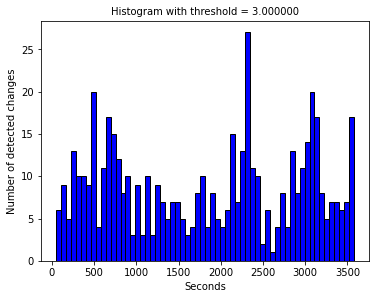

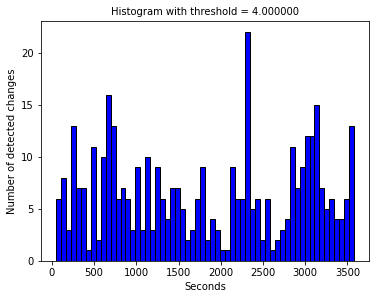

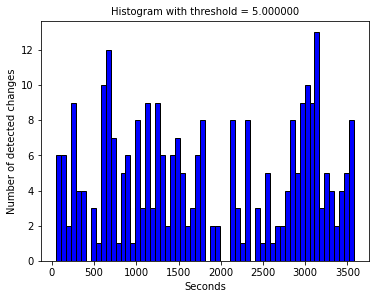

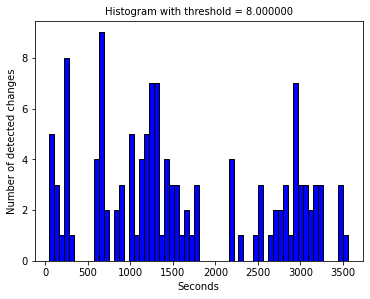

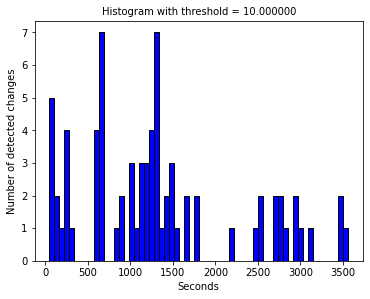

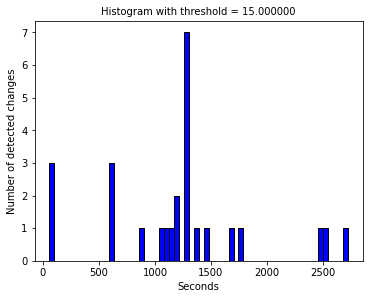

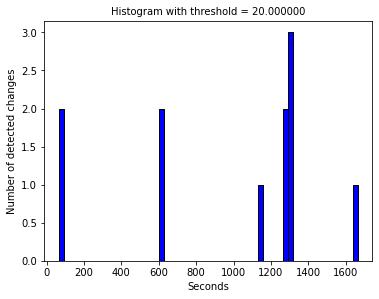

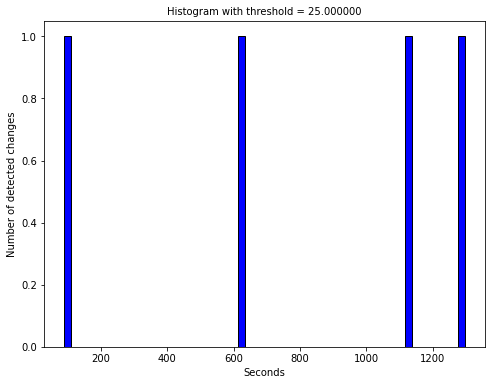

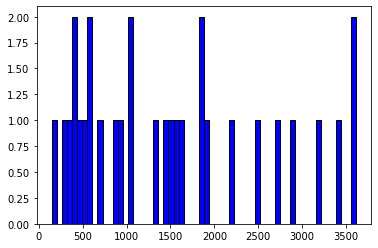

In [ ]:
for i, threshold in enumerate(test_scenes_combined):
    # Set up the plot
    plt.figure(figsize=(20, 15))
    ax = plt.subplot(3, 3, i + 1)
    
    # Draw the plot
    ax.hist(threshold, bins = int(3600/60),
             color = 'blue', edgecolor = 'black')
    
    # Title and labels
    ax.set_title('Histogram with threshold = %f' %  pscene_threshold[i], size = 10)
    ax.set_xlabel('Seconds', size = 10)
    ax.set_ylabel('Number of detected changes', size= 10)

plt.tight_layout()
plt.show()

plt.hist(true_scenes, bins = int(3600/60),
             color = 'blue', edgecolor = 'black')

plt.show()

In [ ]:
!export GOOGLE_APPLICATION_CREDENTIALS=/content/drive/MyDrive/shared/annular-garden-346212-9b1b0c037018.json

!gcloud auth activate-service-account --key-file /content/drive/MyDrive/shared/annular-garden-346212-9b1b0c037018.json

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/drive/MyDrive/shared/annular-garden-346212-9b1b0c037018.json"

client = language_v1.LanguageServiceClient()

def analyze(movie_review_filename):
    """Run a sentiment analysis request on text within a passed filename."""

    with open(movie_review_filename, 'r') as review_file:
        # Instantiates a plain text document.
        content = review_file.read()
        
    encoding_type = language_v1.EncodingType.UTF8
    document = language_v1.types.Document(
        content=content,
        type='PLAIN_TEXT')
    annotations = client.analyze_sentiment(document=document, encoding_type=encoding_type)

    # Print the results
    arrange(annotations)


def analyze_entities(filename):   
    with open(filename, 'r') as review_file:
        # Instantiates a plain text document.
        content = review_file.read()

    encoding_type = language_v1.EncodingType.UTF8
    document = language_v1.types.Document(
        content=content,
        type='PLAIN_TEXT')
    response = client.analyze_entity_sentiment(request = {'document': document, 'encoding_type': encoding_type})
    
    arrange_entities(response)


def arrange_entities(response):
    for entity in response.entities:
        if entity.name.upper() in characters:
            print(u"Representative name for the entity: {}".format(entity.name))
            print(u"Salience score: {}".format(entity.salience))
            sentiment = entity.sentiment
            print(u"Entity sentiment score: {}".format(sentiment.score))
        else:
            print(u"{} not in characters".format(entity.name))


        # # Get entity type, e.g. PERSON, LOCATION, ADDRESS, NUMBER, et al
        # print(u"Entity type: {}".format(language_v1.Entity.Type(entity.type_).name))
        # # Get the salience score associated with the entity in the [0, 1.0] range
        # print(u"Salience score: {}".format(entity.salience))
        # # Get the aggregate sentiment expressed for this entity in the provided document.
        # sentiment = entity.sentiment
        # print(u"Entity sentiment magnitude: {}".format(sentiment.magnitude))
        # print("----------------------------------------")

    # for mention in entity.mentions:
    #         print(u"Mention text: {}".format(mention.text.content))
    #         # Get the mention type, e.g. PROPER for proper noun
    #         print(
    #             u"Mention type: {}".format(language_v1.EntityMention.Type(mention.type_).name)
    #         )

def arrange(annotations):
    score = annotations.document_sentiment.score
    magnitude = annotations.document_sentiment.magnitude 
    idx = 0
    current_dialogue = final_dialogue[idx][1]
    current_sentiments = []
    for index, sentence in enumerate(annotations.sentences):
        if sentence.text.content not in final_dialogue[idx][1]:
            print(sentence.text.content + " not in " + final_dialogue[idx][1])
            sentiment = statistics.mean(current_sentiments)
            final_dialogue[idx].append(sentiment)
            idx += 1
            current_sentiments = []

        print(sentence.text.content + " is in " + final_dialogue[idx][1])
        current_sentiments.append(sentence.sentiment.score)
    
    sentiment = statistics.mean(current_sentiments)
    final_dialogue[idx].append(sentiment)

    for f in final_dialogue:
        print(f)


def print_result(annotations):
    score = annotations.document_sentiment.score
    magnitude = annotations.document_sentiment.magnitude

    for index, sentence in enumerate(annotations.sentences):
        sentence_sentiment = sentence.sentiment.score
        print(sentence)
        final_dialogue[index].append(sentence_sentiment)
        # print('Sentence {} has a sentiment score of {}'.format(
        #     index, sentence_sentiment))

    print('Overall Sentiment: score of {} with magnitude of {}'.format(
        score, magnitude))
    return 0

Activated service account credentials for: [lmorti@annular-garden-346212.iam.gserviceaccount.com]


In [ ]:
#add sentiment analysis to final dialogue
print(len(final_dialogue))
with open(sentiment_analysis, "w") as f:
    for speech in final_dialogue:
        # f.write(u"" + re.sub(r"[.?!\\]", "", speech[1]) + ".")
        # f.write(u"\n")
        f.write(u"" + speech[1] + "\n")


analyze(sentiment_analysis)
# analyze_entities(sentiment_analysis)

848
Dis-mount! is in Dis-mount!
Herman's horsesick! not in Dis-mount!
Herman's horsesick! is in Herman's horsesick!
Chaps, don't anybody wander off. not in Herman's horsesick!
Chaps, don't anybody wander off. is in Chaps, don't anybody wander off. Some of the passageways in here can run for miles.
Some of the passageways in here can run for miles. is in Chaps, don't anybody wander off. Some of the passageways in here can run for miles.
I don't think this is such a good idea. not in Chaps, don't anybody wander off. Some of the passageways in here can run for miles.
I don't think this is such a good idea. is in I don't think this is such a good idea.
What is it? not in I don't think this is such a good idea.
What is it? is in What is it?
Alfred, did you get anything yet? not in What is it?
Alfred, did you get anything yet? is in Alfred, did you get anything yet?
I got something, Garth! not in Alfred, did you get anything yet?
I got something, Garth! is in I got something, Garth!
I got so

In [ ]:
eliminate_char = 0

In [ ]:
# eliminate all characters who only speak once
to_eliminate = {}

for c in characters:
    to_eliminate[c] = 0

print(to_eliminate)

for f in final_dialogue:
    to_eliminate[f[0]] += 1

print(to_eliminate)

eliminate = []
for c, i in enumerate(to_eliminate):
    if to_eliminate[i] <= 3:
        eliminate.append(i)

print(eliminate)

to_elim = []
for c in eliminate:
    for i, f in enumerate(final_dialogue):
        if f[0] == c:
            to_elim.append(i)

print(to_elim)

for f in sorted(to_elim, reverse=True):
    del final_dialogue[f]

eliminate_char = 1

In [ ]:
scene_dialogues = []
character_list = []
scene_combined = {}

for s in scenes:
    for d in final_dialogue:
        if d[2] > scenes[s]['start'] and d[3] < scenes[s]['end']:
            #dialogue is wholly within one scene
            scene_dialogues.append((s, d))
        elif d[2] > scenes[s]['start'] and d[2] < scenes[s]['end'] and d[3] > scenes[s]['end']:
            #dialogue starts in a scene but does not end in this scene
            scene_dialogues.append((s, [d[0],d[1],d[2], scenes[s]['end'], d[4]]))
        elif d[2] < scenes[s]['start'] and d[3] < scenes[s]['start'] and d[3] > scenes[s]['end']:
            #dialogue ends in this scene but does not start in this scene
             scene_dialogues.append((s, [d[0],d[1],scenes[s]['start'], d[3], d[4]]))

for i, j in scene_dialogues:
    scene_combined[i] = []

for i, j in scene_dialogues:
    # if j[0] not in character_list:
    #     character_list.append(j[0])

    scene_combined[i].append(j)

# if eliminate_char == 1:
#     character_list = list(dict.fromkeys([x for x in characters if x not in eliminate]))
# else:
#     character_list = list(dict.fromkeys(characters))

for d in final_dialogue:
    if d[0] not in character_list:
        character_list.append(d[0])

print(character_list)
print(scene_dialogues)
print(scene_combined)
   

['OFFICER', 'FIRST SCOUT', 'SCOUTMASTER', 'HERMAN', 'FEDORA', 'ROSCOE', 'HALFBREED', 'INDY', 'PANAMA HAT', 'HENRY', 'SHERIFF', 'BRODY', 'IRENE', 'DONOVAN', 'ELSA', 'KAZIM', 'BUTLER', 'VOGEL', 'MAN IN CHAIR', 'SALLAH', 'SINISTER MAN', 'SECOND MAN', 'RADIO OPERATOR', 'WOMAN', 'GUARD', 'SULTAN', 'NAZI SOLDIER', 'KNIGHT']
[('5', ['OFFICER', 'Dis-mount!', 117.283, 118.716, 0.0]), ('5', ['FIRST SCOUT', "Herman's horsesick!", 124.991, 127.425, 0.5]), ('6', ['SCOUTMASTER', "Chaps, don't anybody wander off. Some of the passageways in here can run for miles.", 134.067, 140.3, -0.20000000298023224]), ('7', ['HERMAN', "I don't think this is such a good idea.", 150.617, 153.711, -0.699999988079071]), ('7', ['HERMAN', 'What is it?', 157.19, 158.3667000333667, -0.10000000149011612]), ('8', ['FEDORA', 'Alfred, did you get anything yet?', 184.05, 185.642, 0.0]), ('9', ['ROSCOE', 'I got something, Garth!', 191.558, 192.547, 0.30000001192092896]), ('9', ['ROSCOE', 'I got something... I got something righ

In [ ]:
for s in scene_combined:
    print(s)
    print(scene_combined[s])

In [ ]:
graph_matrix = np.zeros((len(character_list), len(character_list)))
current_scene = 0
scene_characters = []
scene_durations = []

for s, d in scene_dialogues:  
    if d[0] not in scene_characters:
        scene_characters.append(d[0])

    #work out a way to calculate weights for each scene individually, sum of total time for each character?

weightings_out = {}
scene_weightings = {}
print(character_list)

for scene in scene_combined:
    for dialogue in scene_combined[scene]:
        if dialogue[0] not in weightings_out:
            weightings_out[dialogue[0]] = 0
        print(dialogue)
        # weightings_out[dialogue[0]] = weightings_out[dialogue[0]] + round(d[3] - d[2], 3)
        weightings_out[dialogue[0]] = weightings_out[dialogue[0]] + round(dialogue[4], 3)


    scene_weightings[scene] = weightings_out
    weightings_out = {}

print(scene_weightings)
longest_dialogue = 0

for i in scene_weightings:
    for j in scene_weightings[i]:
        if scene_weightings[i][j] > longest_dialogue:
            longest_dialogue = scene_weightings[i][j]

['OFFICER', 'FIRST SCOUT', 'SCOUTMASTER', 'HERMAN', 'FEDORA', 'ROSCOE', 'HALFBREED', 'INDY', 'PANAMA HAT', 'HENRY', 'SHERIFF', 'BRODY', 'IRENE', 'DONOVAN', 'ELSA', 'KAZIM', 'BUTLER', 'VOGEL', 'MAN IN CHAIR', 'SALLAH', 'SINISTER MAN', 'SECOND MAN', 'RADIO OPERATOR', 'WOMAN', 'GUARD', 'SULTAN', 'NAZI SOLDIER', 'KNIGHT']
['OFFICER', 'Dis-mount!', 117.283, 118.716, 0.0]
['FIRST SCOUT', "Herman's horsesick!", 124.991, 127.425, 0.5]
['SCOUTMASTER', "Chaps, don't anybody wander off. Some of the passageways in here can run for miles.", 134.067, 140.3, -0.20000000298023224]
['HERMAN', "I don't think this is such a good idea.", 150.617, 153.711, -0.699999988079071]
['HERMAN', 'What is it?', 157.19, 158.3667000333667, -0.10000000149011612]
['FEDORA', 'Alfred, did you get anything yet?', 184.05, 185.642, 0.0]
['ROSCOE', 'I got something, Garth!', 191.558, 192.547, 0.30000001192092896]
['ROSCOE', 'I got something... I got something right here.', 192.625, 195.185, 0.3500000052154064]
['ROSCOE', " Oh

In [ ]:
from networkx.algorithms.community.centrality import girvan_newman
import itertools

comp = girvan_newman(G)
k = 10
for communities in itertools.islice(comp, k):
    print(tuple(sorted(c) for c in communities))


o = tuple(sorted(c) for c in next(comp))
print(o)

(['OFFICER'], ['FIRST SCOUT'], ['SCOUTMASTER'], ['HERMAN'], ['BUTLER', 'FEDORA', 'INDY', 'IRENE', 'KAZIM', 'KNIGHT', 'SHERIFF'], ['HALFBREED', 'ROSCOE'], ['PANAMA HAT'], ['BRODY', 'DONOVAN', 'ELSA', 'HENRY', 'SALLAH', 'SECOND MAN', 'SULTAN', 'VOGEL'], ['MAN IN CHAIR'], ['SINISTER MAN'], ['RADIO OPERATOR'], ['WOMAN'], ['GUARD'], ['NAZI SOLDIER'])
(['OFFICER'], ['FIRST SCOUT'], ['SCOUTMASTER'], ['HERMAN'], ['FEDORA'], ['HALFBREED', 'ROSCOE'], ['BUTLER', 'INDY', 'IRENE', 'KAZIM', 'KNIGHT', 'SHERIFF'], ['PANAMA HAT'], ['BRODY', 'DONOVAN', 'ELSA', 'HENRY', 'SALLAH', 'SECOND MAN', 'SULTAN', 'VOGEL'], ['MAN IN CHAIR'], ['SINISTER MAN'], ['RADIO OPERATOR'], ['WOMAN'], ['GUARD'], ['NAZI SOLDIER'])
(['OFFICER'], ['FIRST SCOUT'], ['SCOUTMASTER'], ['HERMAN'], ['FEDORA'], ['HALFBREED', 'ROSCOE'], ['BUTLER', 'INDY', 'IRENE', 'KAZIM', 'KNIGHT', 'SHERIFF'], ['PANAMA HAT'], ['BRODY', 'DONOVAN', 'ELSA', 'HENRY', 'SULTAN', 'VOGEL'], ['MAN IN CHAIR'], ['SALLAH', 'SECOND MAN'], ['SINISTER MAN'], ['RADIO OP

In [ ]:
#collect durations into the graph matrix
idx_in = []

for scene in scene_weightings:
    for char in scene_weightings[scene]:
        idx_out = character_list.index(char)
        for listener in scene_weightings[scene]:
            idx_in.append(character_list.index(listener))

        # print(idx_out)
        # print(idx_in)

        for idx in idx_in:
            graph_matrix[idx_out][idx] += scene_weightings[scene][char]

        idx_in = []

df = pd.DataFrame(graph_matrix)
df = (df).round(3)
df.columns = character_list
df.index = character_list
# print(df)

def make_edge(x, y, width, xtext, ytext, weight):
    """
    Args:
        x: a tuple of the x from and to, in the form: tuple([x0, x1, None])
        y: a tuple of the y from and to, in the form: tuple([y0, y1, None])
        width: The width of the line

    Returns:
        a Scatter plot which represents a line between the two points given. 
    """
    if weight > 0:
        return  go.Scatter(
                    x=x,
                    y=y,
                    line=dict(width=width, color='rgba(0, 0, 255, 0.5)'),
                    hoverinfo='text',
                    textposition="bottom right",
                    text=str(weight),
                    mode='lines')
    else:
        return  go.Scatter(
                    x=x,
                    y=y,
                    line=dict(width=width, color='rgba(255, 0, 0, 0.5)'),
                    hoverinfo='text',
                    text=str(weight),
                    mode='lines')
                    

#generate the graph for degree centrality including all characters
plt.figure(figsize=(20,12))

G = nx.from_pandas_adjacency(df, nx.DiGraph)

def create_graph(G):

    betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
    eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality

    # Assign each to an attribute in your network
    nx.set_node_attributes(G, betweenness_dict, 'betweenness')
    nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')


    weight = nx.get_edge_attributes(G, "weight")
    eigenvector_centrality = [round((x*100)+15, 3) for x in list(nx.get_node_attributes(G, 'eigenvector').values())]
    pos = nx.circular_layout(G)
    nx.set_node_attributes(G, pos, "pos")

    weight_list = np.array([[f'{w}' for w in list(nx.get_edge_attributes(G, 'weight').values())]]).astype(float).round(3)
    # weight_list = (weight_list - weight_list.min())/ (weight_list.max() - weight_list.min())

    edge_traces = []
    edge_set = []
    xtext = []
    ytext = []

    for edge in G.edges.data():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        xtext.append((x1-x0)/5 + x0)
        ytext.append((y1-y0)/5 + y0)
        graphed_edge = make_edge(
            tuple([x0, x1, None]),
            tuple([y0, y1, None]),
            np.abs(edge[2]['weight'] / (np.abs(weight_list).max())) * 20,
            (x0+x1)/2,
            (y0+y1)/2,
            edge[2]['weight']
        )
        edge_traces.append(graphed_edge)



    eweights_trace = go.Scatter(x=xtext, y=ytext, mode='text',
        marker_size=0.5,
        text=list(weight.values()),
        textposition='middle center',
        hovertemplate='%{text}')


    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)

    enodes_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='text',
        text=character_list,
        textfont=dict(
            size=14,
            family='Arial'
        )
        )

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='Jet',
            # reversescale=True,
            color=[],
            size=eigenvector_centrality,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    node_adjacencies = []
    node_text = []
    degree_centrality = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append(character_list[node]+', # of connections: '+str(len(adjacencies[1])))
        degree_centrality.append(len(adjacencies[1]))


    edge_sentiment = []
        
    for u, v, weight in G.edges(data="weight"):
        if weight is not None:
            # Do something useful with the edges
            edge_sentiment.append(weight)

    # dc = pd.DataFrame(degree_centrality)
    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    fig = go.Figure(data=edge_traces + [node_trace] + [enodes_trace],# + [eweights_trace],
                layout=go.Layout(
                    title='Graph Showing Degree Centrality of Each Node',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    # annotations=[ dict(
                    #     text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    #     showarrow=False,
                    #     xref="paper", yref="paper",
                    #     x=0.005, y=-0.002 ) ],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    fig.update_layout(
        autosize=False,
        width=1520,
        height=700,)
    fig.show()

create_graph(G)

<Figure size 1440x864 with 0 Axes>

In [ ]:
#Some Metrics for infomation
#density
density = nx.density(G)
print("Network density:", density)
#dispersion
dispersion = nx.dispersion(G)
print(dispersion["ANDY"])
print(dispersion["RED"])
print(dispersion["HADLEY"])
print(dispersion["NORTON"])

Network density: 0.08637747336377473


KeyError: ignored

In [ ]:
import plotly.express as px

fig = px.scatter(x=scene_characters, y=degree_centrality)
fig.update_xaxes(categoryorder='total descending')
fig.show()

ValueError: ignored

In [ ]:
#generate df for network not including indy
adj_mat_noIndy = np.zeros((len(character_list)-1, len(character_list)-1))
idx_in = []
for scene in scene_weightings:
    for char in scene_weightings[scene]:
        if char == 'INDY':
            continue

        idx_out = scene_characters.index(char)
        if idx_out > 8:
            idx_out -= 1

        for listener in scene_weightings[scene]:
            if listener == 'INDY':
                continue
            idx_in_temp = scene_characters.index(listener)
            if idx_in_temp > 8:
                idx_in_temp -= 1

            idx_in.append(idx_in_temp)

        for idx in idx_in:
            adj_mat_noIndy[idx_out][idx] += scene_weightings[scene][char]

        idx_in = []


df_noIndy = pd.DataFrame(adj_mat_noIndy)
df_noIndy = df_noIndy.round(3)
df_noIndy.columns = [x for i,x in enumerate(scene_characters) if x!='INDY']
df_noIndy.index = [x for i,x in enumerate(scene_characters) if x!='INDY']


G = nx.from_pandas_adjacency(df_noIndy, nx.DiGraph)
weight = nx.get_edge_attributes(G, "weight")
pos = nx.spring_layout(G)
nx.set_node_attributes(G, pos, "pos")

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

weight_list = []
for i in weight:
    weight_list.append(weight[i])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Reds',
        # reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    if node >= 8:
        node+=1
    node_text.append(scene_characters[node]+', # of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Graph Showing Degree Centrality of Each Node without Indy',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                # annotations=[ dict(
                #     text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                #     showarrow=False,
                #     xref="paper", yref="paper",
                #     x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

In [ ]:
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community import k_clique_communities
import itertools

comp = girvan_newman(G)
k = 5
for communities in itertools.islice(comp, k):
    print(tuple(sorted(c) for c in communities))


K5 = nx.convert_node_labels_to_integers(G, first_label=2)
G.add_edges_from(K5.edges())
c = list(k_clique_communities(G, 4))

(['OFFICER'], ['FIRST SCOUT'], ['SCOUTMASTER'], ['FEDORA', 'HALFBREED', 'HERMAN', 'MAN', 'PANAMA HAT', 'ROSCOE', 'ROUGH RIDER', 'SHERIFF'], ['BRODY', 'BUTLER', 'DONOVAN', 'ELSA', 'HENRY', 'KNIGHT', 'MAN IN CHAIR', 'NAZI SOLDIER', 'SALLAH', 'SECOND MAN', 'SULTAN', 'VOGEL'], ['IRENE', 'MALE STUDENT'], ['KAZIM'], ['WOMAN'])
(['OFFICER'], ['FIRST SCOUT'], ['SCOUTMASTER'], ['FEDORA', 'HALFBREED', 'HERMAN', 'MAN', 'PANAMA HAT', 'ROSCOE', 'ROUGH RIDER', 'SHERIFF'], ['BRODY', 'BUTLER', 'DONOVAN', 'ELSA', 'HENRY', 'KNIGHT', 'MAN IN CHAIR', 'NAZI SOLDIER', 'SALLAH', 'SECOND MAN', 'VOGEL'], ['IRENE', 'MALE STUDENT'], ['KAZIM'], ['WOMAN'], ['SULTAN'])
(['OFFICER'], ['FIRST SCOUT'], ['SCOUTMASTER'], ['FEDORA', 'HALFBREED', 'HERMAN', 'MAN', 'PANAMA HAT', 'ROSCOE', 'ROUGH RIDER', 'SHERIFF'], ['BRODY', 'DONOVAN', 'ELSA', 'HENRY', 'KNIGHT', 'MAN IN CHAIR', 'NAZI SOLDIER', 'SALLAH', 'SECOND MAN', 'VOGEL'], ['IRENE', 'MALE STUDENT'], ['KAZIM'], ['BUTLER'], ['WOMAN'], ['SULTAN'])
(['OFFICER'], ['FIRST SCO

NetworkXNotImplemented: ignored